In [1]:
import numpy as np
import numpy.matlib
import matplotlib.pyplot as plt
from scipy import signal
import librosa
import IPython.display

Text(0.5, 1.0, 'Magnitude response of 1 / cos(2π f L / c) (L = 0.17 m, c = 340 m/s)')

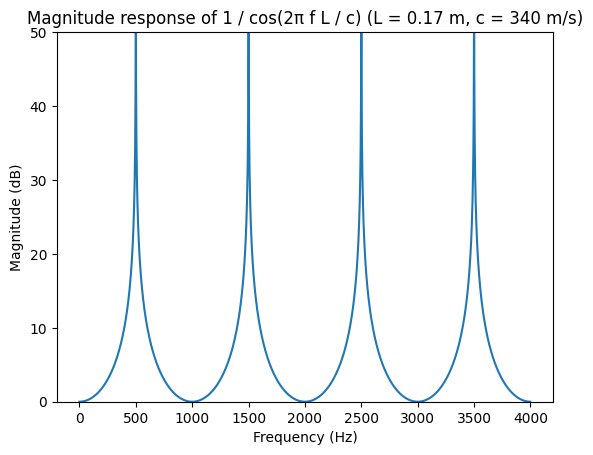

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# ============================================
# 管の共鳴を簡易モデルで可視化するコード
#   |H(f)| = 1 / |cos(2π f L / c)|
#
# 想定している物理モデル：
#   - 長さ L の一様な音響管（声道や管楽器の非常に単純化したモデル）
#   - 音速 c [m/s]
#   - 周波数 f に対する伝達関数の大きさを
#       H(f) = 1 / cos(kL)   （k = 2π f / c）
#     という形で近似したもの（cos が 0 に近づく周波数で強い共鳴が出る）
# ============================================

# 音速 [m/s]
c = 340

# 管の長さ [m]
# 0.17 m ≒ 17 cm なので、人間の声道の平均的な長さを大まかに想定している値。
# この長さによって共鳴（フォルマント）周波数の位置が決まる。
length = 0.17

# サンプリングレート [Hz]
# ここでは 8 kHz を想定。周波数軸は 0〜fs/2（ナイキスト周波数）までを描画する。
fs = 8000

# 周波数軸 [Hz] の生成
# np.arange(0, fs/2) で 0,1,2,...,(fs/2 - 1) [Hz] を生成する。
# 離散的な周波数点で H(f) の値を計算し、周波数応答を可視化する。
frequency = np.arange(0, fs / 2)

# ============================================
# 伝達関数 H(f) = 1 / cos(2π f L / c) の大きさ |H(f)| を計算
# ============================================
# kL = 2π f L / c  は波数 k と管長 L の積に相当。
# cos(kL) が 0 に近づく周波数（共鳴周波数）で |H(f)| が非常に大きくなる。
#
# 共鳴周波数の条件：
#   cos(2π f L / c) = 0
#   ⇒ 2π f L / c = (2n+1) π/2   （n = 0,1,2,...）
#   ⇒ f = (2n+1) c / (4L)
# したがって、(2n+1) 次の奇数倍で共鳴ピークが現れる。
#
# np.abs(1/np.cos(...)) で振幅 |H(f)| を計算し、
# その後 20*log10 で dB スケールに変換してプロットする。
H_mag = np.abs(1 / np.cos(2 * np.pi * frequency * length / c))

# ============================================
# 周波数応答（振幅スペクトル）をプロット
# ============================================
plt.plot(frequency, 20 * np.log10(H_mag))

# y 軸を 0〜50 dB の範囲に制限
# 共鳴周波数付近では理論上振幅が無限大に発散するが、
# プロットとしては 0〜50 dB 程度に切ることで、
# 共鳴ピークの位置だけを見やすく表示している。
plt.ylim(0, 50)

# 軸ラベルなどを付けると、何を見ているかがより明確になる（任意）
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude (dB)")
plt.title("Magnitude response of 1 / cos(2π f L / c) (L = 0.17 m, c = 340 m/s)")

# plt.show()  # スクリプトとして実行する場合は明示的に表示する

Text(0.5, 1.0, 'Frequency response of H(z) = 2 z^{-4} / (1 + z^{-8})')

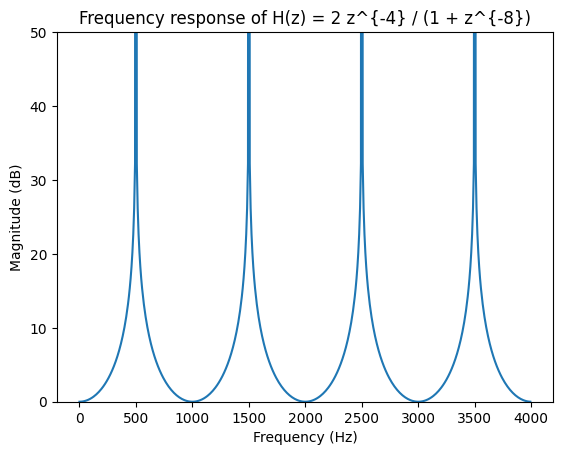

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

# ============================================
# IIR フィルタ（共鳴を持つフィードバック構造）の周波数特性を可視化するコード
#
# 伝達関数 H(z) = B(z) / A(z) を
#   B(z) = 2 z^{-4}
#   A(z) = 1 + z^{-8}
# とおいたときの周波数応答 |H(e^{jω})| を plot している。
#
# ・分子 B(z) = 2 z^{-4}  → 4 サンプルの純粋な遅延（位相シフト）＋ゲイン 2
# ・分母 A(z) = 1 + z^{-8} → 8 サンプル遅延フィードバックを持つ共鳴構造
#
# A(z) の零点方程式 1 + z^{-8} = 0 から、
#   z^{-8} = -1 → z = exp(j (π + 2πk) / 8), k=0,...,7
# の位置にポールが存在し、対応する周波数で共鳴（ピーク）が現れる。
# ============================================

# サンプリングレート [Hz]
sr = 8000

# ============================================
# 1. フィルタ係数 b, a の設定
# ============================================
# 信号処理ライブラリでは一般に、
#   H(z) = (b[0] + b[1] z^{-1} + ... + b[M] z^{-M}) /
#          (a[0] + a[1] z^{-1} + ... + a[N] z^{-N})
# としてフィルタを表現する。
#
# ここでは、
#   b[4] = 2  → B(z) = 2 z^{-4}
#   a[0] = 1, a[8] = 1 → A(z) = 1 + z^{-8}
#
# となるようにゼロ配列を用意したあと、必要な位置だけ代入している。
b = np.zeros(5)  # 長さ 5 の分子係数（最大 z^{-4} まで）
a = np.zeros(9)  # 長さ 9 の分母係数（最大 z^{-8} まで）

# 分子：4 サンプル遅延のタップにゲイン 2
b[4] = 2

# 分母：z^0（現在サンプル）と z^{-8} の係数を 1 に設定
#       → A(z) = 1 + z^{-8}
a[0] = 1
a[8] = 1

# ============================================
# 2. 周波数応答の計算（signal.freqz）
# ============================================
# signal.freqz(b, a) は離散時間フィルタ H(z) の周波数応答
#   H(e^{jω}) を 0〜π [rad/sample] の範囲で計算してくれる。
#
# 戻り値：
#   - w : 正規化角周波数 [rad/sample]
#   - H : 複素周波数応答 H(e^{jω})
w, H = signal.freqz(b, a)

# ============================================
# 3. 角周波数 w を実周波数 f [Hz] に変換
# ============================================
# 離散時間の角周波数 ω [rad/sample] と実周波数 f [Hz] の関係は
#   ω = 2π f / sr
# なので、
#   f = ω sr / (2π)
# として周波数軸を Hz に変換する。
f = sr * w / (2 * np.pi)

# ============================================
# 4. 振幅スペクトル（dB）のプロット
# ============================================
# np.abs(H) : 複素周波数応答の絶対値 → 振幅スペクトル |H(e^{jω})|
# 20*log10(|H|) : dB 表示に変換（音響・信号処理で一般的な表現）
#
# A(z) = 1 + z^{-8} のポール位置に対応する周波数では、
# |H| が大きくなり、グラフ上で鋭いピークとして現れる。
plt.plot(f, 20 * np.log10(np.abs(H)))

# y 軸のスケールを 0〜50 dB に制限
# 共鳴ピークが非常に高くなりうるため、見やすい範囲にクリップしている。
plt.ylim([0, 50])

# 軸ラベルなど（任意で追加）
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude (dB)")
plt.title("Frequency response of H(z) = 2 z^{-4} / (1 + z^{-8})")

# plt.show()  # スクリプトとして実行する場合は明示的に描画

Text(0.5, 0, 'Time (s)')

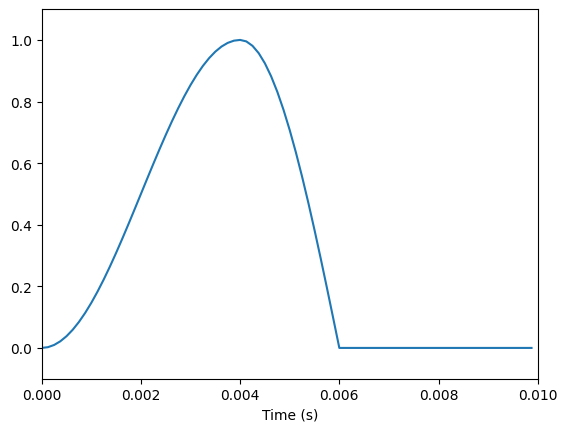

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# ============================================
# 疑似声門波のような「1周期分の包絡」を時間軸上に設計するコード
# - サンプリング周波数 sr = 8 kHz
# - 全長 0.01 秒（10 ms）の中で
#   * T1 = 4 ms : 立ち上がり部分（Hann 型で 0→1）
#   * T2 = 2 ms : 立ち下がり部分（cos 波で 1→0）
#   * 残り      : 0（閉鎖区間）
# という 3 区間を結合して 1 つの波形 g(t) を作っている。
# ============================================

# サンプリングレート [Hz]
sr = 8000

# 立ち上がり区間の長さ [s]
T1 = 0.004  # 4 ms

# 立ち下がり区間の長さ [s]
T2 = 0.002  # 2 ms

# ============================================
# 1. 立ち上がり区間（0〜T1）の時間軸と波形 g1
# ============================================

# t1: 0 から T1 未満まで、1/sr 間隔の時間軸
#     sr=8000 のとき 1 サンプル = 0.000125 秒なので、
#     約 32 サンプルで 0〜4 ms を表現している。
t1 = np.arange(0, T1, 1 / sr)

# g1: Hann 窓の前半に相当する形で、0 → 1 へ滑らかに立ち上がる。
#   g1(t) = 0.5 * (1 - cos(π t / T1))
# と同値であり、t=0 で g1=0、t=T1 で g1=1 になる。
# 立ち上がりを滑らかにすることで、高周波成分を抑えた包絡になる。
g1 = 0.5 * (1 - np.cos(2 * np.pi * t1 / 2 / T1))

# ============================================
# 2. 立ち下がり区間（T1〜T1+T2）の時間軸と波形 g2
# ============================================

# t2: T1 から T1+T2 未満までの時間軸（同じく 1/sr 間隔）
#     ここでは 4〜6 ms の区間を表している。
t2 = np.arange(T1, T1 + T2, 1 / sr)

# g2: cos 波を利用した 1 → 0 の減衰部分。
#   g2(t) = cos( (π/2) * (t - T1) / T2 )
# なので、
#   t = T1          のとき cos(0)     = 1
#   t = T1 + T2 のとき cos(π/2) = 0
# となり、立ち下がりが滑らかに 1→0 へ向かう。
g2 = np.cos(2 * np.pi * (t2 - T1) / 4 / T2)

# ============================================
# 3. 残り区間（T1+T2〜0.01 s）の時間軸と波形 g3
# ============================================

# t3: T1+T2 から 0.01 秒までの時間軸。
#     全体の長さを 10 ms に固定するための「閉鎖区間」に相当する。
t3 = np.arange(T1 + T2, 0.01, 1 / sr)

# g3: この区間では振幅 0（無音・閉鎖）とする。
g3 = np.zeros(t3.shape)

# ============================================
# 4. 3 区間を結合して 1 つの波形 g(t) を作成
# ============================================

# hstack で [g1, g2, g3] を連結し、0→1→0→0 の形の包絡を作る。
g = np.hstack((g1, g2, g3))

# 同様に時間軸 t も [t1, t2, t3] を結合して、g と対応を取る。
t = np.hstack((t1, t2, t3))

# ============================================
# 5. 波形のプロット
# ============================================

plt.plot(t, g)

# 全体 0〜10 ms の範囲だけを表示（それより外は存在しないが念のため）
plt.xlim([0, 0.01])

# 縦軸は -0.1〜1.1 にして、0〜1 の波形が少し余裕を持って見えるようにする。
plt.ylim([-0.1, 1.1])

plt.xlabel("Time (s)")
# plt.ylabel('Amplitude')  # 必要なら縦軸ラベルも追加

# plt.show()  # スクリプトで実行する場合は明示的に表示

Text(0.5, 1.0, 'Magnitude spectrum of glottal-like envelope g(t)')

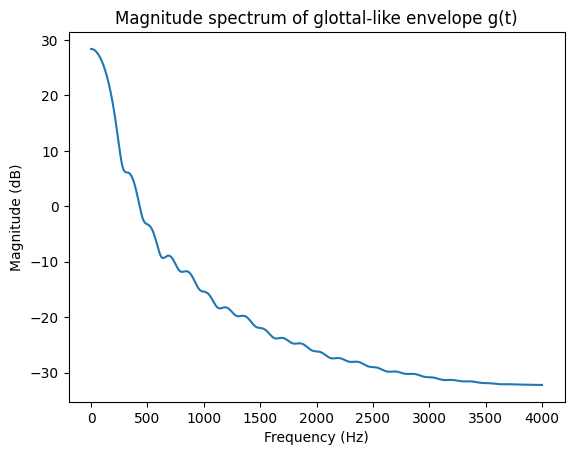

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# ============================================
# g(t) の周波数特性を確認するためのコード
# - 直前までに作成した 1 周期分の包絡 g（長さは 0.01 s 程度）に対して
#   実数 FFT（rFFT）を行い、振幅スペクトルを dB で描画する。
# - g は時間領域で滑らかに 0→1→0→0 と変化するパルス状の信号なので、
#   そのスペクトルは「広帯域だが高周波ほど減衰する」形になる。
# ============================================

# 既存の図を閉じてから新しいプロットを描く
plt.close()

# FFT のポイント数
# --------------------------------------------
# nFFT を g の長さ以上に取ることで、ゼロパディングによって
# 周波数軸の刻み幅を細かくできる（スペクトルの描画が滑らかになる）。
# 実際の周波数分解能自体は観測時間（ここでは約 10 ms）で決まり、
# nFFT を増やしても理論的な分解能は変わらない点に注意。
nFFT = 1024

# 実数信号 g に対して rFFT（片側スペクトル）を計算
# --------------------------------------------
# np.fft.rfft は 0〜ナイキスト周波数までの複素スペクトルを返す。
# G[k] は周波数 bin k に対応する複素振幅で、
# 振幅スペクトルは |G[k]|、位相スペクトルは arg(G[k]) となる。
G = np.fft.rfft(g, nFFT)

# 周波数軸 [Hz] の計算
# --------------------------------------------
# np.fft.rfftfreq(nFFT, 1/sr) により、
# 各 bin k が何 Hz に対応するかを計算できる。
# Δf = sr / nFFT となり、ここでは 8000 / 1024 ≒ 7.8125 Hz 間隔。
frequency = np.fft.rfftfreq(nFFT, 1 / sr)

# 振幅スペクトルの dB 表示
# --------------------------------------------
# np.abs(G) : 複素スペクトルの絶対値 → 振幅スペクトル
# 20*log10(|G|) : 振幅を dB スケールに変換
#
# 数値的には |G|=0 の bin で log10(0) → -inf になる可能性があるので、
# 実務コードでは小さな ε を足しておくと安全：
#   20*np.log10(np.abs(G) + 1e-12)
plt.plot(frequency, 20 * np.log10(np.abs(G)))

plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude (dB)")
plt.title("Magnitude spectrum of glottal-like envelope g(t)")

# plt.show()  # スクリプトとして実行する場合に使用